In [2]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square,create_rectangle,CellType
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)

mesh = create_rectangle(MPI.COMM_WORLD,[[0,0], [22,4.1]],[220,41])
t = 0
T = 10
num_steps = 1500
dt = T / num_steps

In [3]:
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

In [4]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [5]:
def walls(x):
    return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

def inflow(x):
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow)
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q)

def outflow(x):
    return np.isclose(x[0], 22)

outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]

In [6]:
u_n = Function(V)
u_n.name = "u_n"
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0, 0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

In [7]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor


def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))


In [8]:
A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

In [9]:
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t)

In [10]:
def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4 * x[1] * (1.0 - x[1])
    return values


u_ex = Function(V)
u_ex.interpolate(u_exact)

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

In [11]:
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_.x.petsc_vec)
    u_.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.x.petsc_vec)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.x.petsc_vec)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
# Close xmdf file
vtx_u.close()
vtx_p.close()
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

Time 0.01, L2-error 2.00e+02, Max error 5.08e+01
Time 0.14, L2-error 2.00e+02, Max error 5.09e+01
Time 0.27, L2-error 2.00e+02, Max error 5.09e+01
Time 0.41, L2-error 2.01e+02, Max error 5.10e+01
Time 0.54, L2-error 2.01e+02, Max error 5.10e+01
Time 0.67, L2-error 2.01e+02, Max error 5.11e+01
Time 0.81, L2-error 2.02e+02, Max error 5.11e+01
Time 0.94, L2-error 2.02e+02, Max error 5.12e+01
Time 1.07, L2-error 2.02e+02, Max error 5.12e+01
Time 1.21, L2-error 2.02e+02, Max error 5.13e+01
Time 1.34, L2-error 2.03e+02, Max error 5.13e+01
Time 1.47, L2-error 2.03e+02, Max error 5.14e+01
Time 1.61, L2-error 2.03e+02, Max error 5.14e+01
Time 1.74, L2-error 2.03e+02, Max error 5.14e+01
Time 1.87, L2-error 2.04e+02, Max error 5.15e+01
Time 2.01, L2-error 2.04e+02, Max error 5.15e+01
Time 2.14, L2-error 2.04e+02, Max error 5.15e+01
Time 2.27, L2-error 2.04e+02, Max error 5.16e+01
Time 2.41, L2-error 2.04e+02, Max error 5.16e+01
Time 2.54, L2-error 2.05e+02, Max error 5.16e+01
Time 2.67, L2-error 

In [12]:
from ufl import SpatialCoordinate, conditional, ge, le
# Get the minimum and maximum x-coordinates of the mesh
x_min = 1
x_max = mesh.geometry.x[:, 0].max()

# Define the interval for calculations
interval = 1

# Create lists to store the results
flow_results = []
pressure_results = []

# Extract the normal component of velocity (u_x in 2D)
u_sub = u_n.sub(0)

# Define measures and spatial coordinates
dx = Measure("dx", domain=mesh)
x = SpatialCoordinate(mesh)

# Loop through the x-coordinates at regular intervals
for x_pos in np.arange(x_min+2*interval, x_max-1, interval):
    # Define a slice at the current x-coordinate
    slice_condition = conditional(ge(x[0], x_pos - 5e-1), 1.0, 0.0) * conditional(le(x[0], x_pos + 5e-1), 1.0, 0.0)
    
    # Calculate mass flow rate at the current slice
    mass_flow = assemble_scalar(form(u_sub * slice_condition * dx))

    # Calculate average pressure at the current slice
    pressure_avg = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx))
    
    # Append the results to the lists
    flow_results.append((x_pos, mass_flow))
    pressure_results.append((x_pos, pressure_avg))

# Communicate results across MPI processes
if MPI.COMM_WORLD.size > 1:
    flow_results = MPI.COMM_WORLD.allgather(flow_results)
    flow_results = [item for sublist in flow_results for item in sublist]
    pressure_results = MPI.COMM_WORLD.allgather(pressure_results)
    pressure_results = [item for sublist in pressure_results for item in sublist]

# Sort results by x-coordinate
flow_results.sort(key=lambda x: x[0])
#pressure_results.sort(key=lambda x: x[0])



In [1]:
import ipyparallel as ipp
def mpi_example():
    comm = MPI.COMM_WORLD
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"

with ipp.Cluster(engines='mpi', n=4) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    r = view.apply_sync(mpi_example)
    # Retrieve and print t

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

Stopping engine(s): 1728403434
engine set stopped 1728403434: {'exit_code': 0, 'pid': 1028, 'identifier': 'ipengine-1728403433-h2wl-1728403434-980'}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 997, 'identifier': 'ipcontroller-1728403433-h2wl-980'}


In [13]:
import matplotlib.pyplot as plt
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))


In [15]:
values[:,1]

array([ 2.13515537e-11,  4.90417275e-11, -2.04345961e-06, ...,
        3.03133002e-04,  3.03657046e-04,  2.99029078e-04])

In [89]:
import numpy as np
import dolfinx

# Assuming u_n is your DOLFINx function and mesh is your mesh
mesh = u_n.function_space.mesh

# Get the mesh geometry (coordinates of mesh vertices)
x = mesh.geometry.x

# Get the number of points
num_points = x.shape[0]

# Create a BoundingBoxTree
tree = dolfinx.geometry.BoundingBoxTree(mesh)

# Compute collisions for each point
cell_indices = dolfinx.geometry.compute_colliding_cells(tree, mesh, x)

# Remove any -1 values (points outside the mesh)
valid_points = cell_indices != -1
x_valid = x[valid_points]
cell_indices_valid = cell_indices[valid_points]

# Evaluate the function at the valid mesh vertices
values = u_n.eval(x_valid, cell_indices_valid)


TypeError: compute_colliding_cells(): incompatible function arguments. The following argument types are supported:
    1. compute_colliding_cells(mesh: dolfinx.cpp.mesh.Mesh_float32, candidate_cells: dolfinx.cpp.graph.AdjacencyList_int32, points: ndarray[dtype=float32, writable=False, shape=(3), order='C']) -> dolfinx.cpp.graph.AdjacencyList_int32
    2. compute_colliding_cells(mesh: dolfinx.cpp.mesh.Mesh_float32, candidate_cells: dolfinx.cpp.graph.AdjacencyList_int32, points: ndarray[dtype=float32, writable=False, shape=(*, 3), order='C']) -> dolfinx.cpp.graph.AdjacencyList_int32
    3. compute_colliding_cells(mesh: dolfinx.cpp.mesh.Mesh_float64, candidate_cells: dolfinx.cpp.graph.AdjacencyList_int32, points: ndarray[dtype=float64, writable=False, shape=(3), order='C']) -> dolfinx.cpp.graph.AdjacencyList_int32
    4. compute_colliding_cells(mesh: dolfinx.cpp.mesh.Mesh_float64, candidate_cells: dolfinx.cpp.graph.AdjacencyList_int32, points: ndarray[dtype=float64, writable=False, shape=(*, 3), order='C']) -> dolfinx.cpp.graph.AdjacencyList_int32

Invoked with types: dolfinx.mesh.Mesh, dolfinx.mesh.Mesh, ndarray

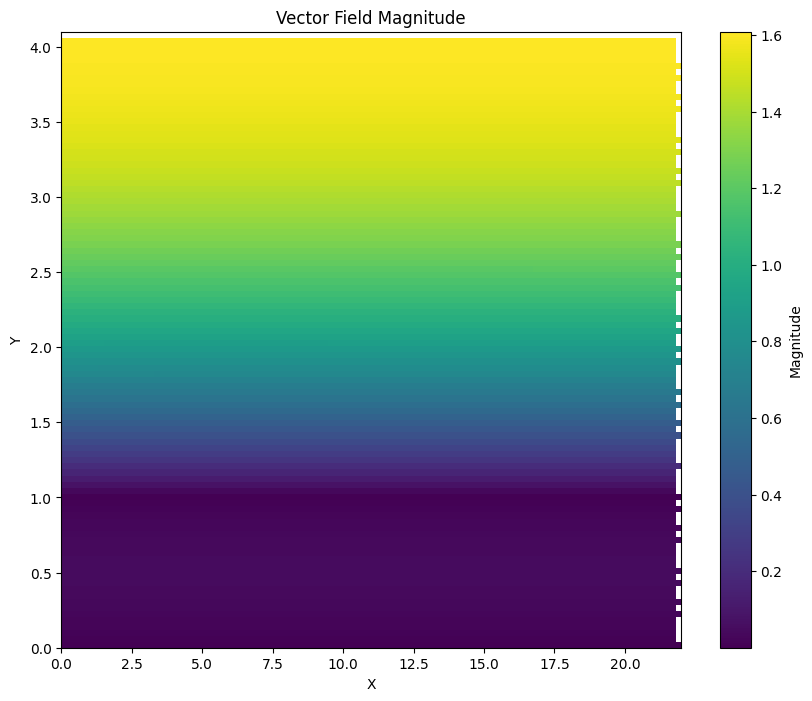

In [16]:
x_min, x_max = np.min(geometry[:, 0]), np.max(geometry[:, 0])
y_min, y_max = np.min(geometry[:, 1]), np.max(geometry[:, 1])

# Create a regular grid
grid_size = 100  # Adjust this for higher/lower resolution
xi = np.linspace(x_min, x_max, grid_size)
yi = np.linspace(y_min, y_max, grid_size)
xi, yi = np.meshgrid(xi, yi)

# Interpolate your scattered data onto the regular grid
# We'll use the magnitude of the vectors for this example
from scipy.interpolate import griddata
magnitudes = np.linalg.norm(values, axis=1)
zi = griddata((geometry[:, 0], geometry[:, 1]), magnitudes, (xi, yi), method='linear')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Use imshow to create a color plot
im = ax.imshow(zi, extent=[x_min, x_max, y_min, y_max], origin='lower', 
               cmap='viridis', aspect='auto')

# Add a colorbar
cbar = plt.colorbar(im)
cbar.set_label('Magnitude')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Vector Field Magnitude')

# Save the figure
plt.savefig('matplotlib_imshow.pdf')

# Show the plot
plt.show()

In [1]:
u_n.eval(np.arange(73206).reshape(-1,3),np.arange(73206/3))
u_n.x.array.shape

NameError: name 'u_n' is not defined

In [57]:
mfr_a = rho.value*(2.2*.41**3)/(12*mu.value)
print(mfr_a)
flow_results

0.012635516666666664


[(3.0, 3.3681471954486226),
 (4.0, 3.3681427329677684),
 (5.0, 3.368154064973052),
 (6.0, 3.3681664333040904),
 (7.0, 3.368174852732738),
 (8.0, 3.3681792583807613),
 (9.0, 3.3681811420977295),
 (10.0, 3.3681819171230063),
 (11.0, 3.3681824442797184),
 (12.0, 3.368183084902287),
 (13.0, 3.3681839055679266),
 (14.0, 3.368184857967304),
 (15.0, 3.3681858754061587),
 (16.0, 3.368186909179621),
 (17.0, 3.3681879287745646),
 (18.0, 3.3681889047707405),
 (19.0, 3.3681897548851483),
 (20.0, 3.3681901794349454)]

In [17]:
ux = u_n.sub(0)
interval = 2.1e-2
slice_condition = conditional(ge(x[0], 1.-interval), 1.0, 0.0)*\
            conditional(le(x[0], 1.+interval), 1.0, 0.0)
# Calculate the mass flow rate
mass_flow_rate = rho.value * assemble_scalar(form(ux*slice_condition * dx))
mass_flow_rate
sat = (slice_condition * ux)
sat

NameError: name 'conditional' is not defined

In [30]:
sat = (slice_condition * ux)
sat

Product(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 2, gll_warped, unset, False, float64, [])), 11), Product(Conditional(LE(Indexed(SpatialCoordinate(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0)), MultiIndex((FixedIndex(0),))), FloatValue(1.021)), FloatValue(1.0), Zero((), (), ())), Conditional(GE(Indexed(SpatialCoordinate(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0)), MultiIndex((FixedIndex(0),))), FloatValue(0.979)), FloatValue(1.0), Zero((), (), ()))))

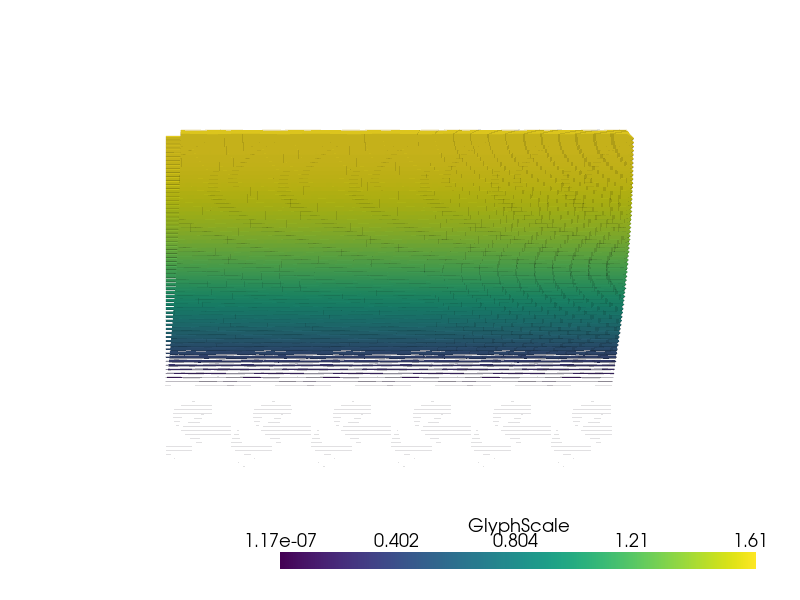

In [17]:
import pyvista
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.7)

# Create a pyvista-grid for the mesh
#mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
#grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
#plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.window_size = [800, 600]
plotter.set_scale(yscale=4)
plotter.view_xy()
plotter.save_graphic("glyphs2.pdf",title='PyVista Export')
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("velocity_field.pdf")